In [79]:
import psycopg2
import pandas as pd
import numpy as np
import os
import re
import geopandas as gpd
import matplotlib.pyplot as plt

from shapely.ops import unary_union
from dotenv import load_dotenv
from datetime import datetime
from azure.storage.blob import BlobServiceClient, ContainerClient
from tqdm import tqdm

In [34]:
load_dotenv()


POSTGIS_CONN = {
    "dbname": os.getenv("DB_NAME", "your_database"),
    "user": os.getenv("DB_USER", "your_username"),
    "password": os.getenv("DB_PASSWORD", "your_password"),
    "host": os.getenv("DB_HOST", "localhost"),
    "port": os.getenv("DB_PORT", "5432"),
}


account_url = os.getenv('AZURE_ACCOUNT_URL', 'https://your-account.blob.core.windows.net')
container = os.getenv('AZURE_CONTAINER', 'your-container-name')
sas_token = os.getenv('AZURE_SAS_TOKEN', 'your-sas-token-here')

## 1. Fetch Video Records from Database

In [35]:
roi = gpd.read_file('../../data/playgroundROI.gpkg')
if roi.crs is None:
    raise ValueError("El GeoPackage no tiene CRS. Asigna uno correcto o reproyecta.")
if roi.crs.to_epsg() != 4326:
    roi = roi.to_crs(epsg=4326)

roi_geom = unary_union(roi.geometry)
roi_wkt = roi_geom.wkt

# SQL query to fetch records within ROI
SQL_QUERY = """
WITH roi as (
  SELECT ST_GeomFromText(%s, 4326) AS geom
),
filtered as (
  SELECT p.*
  FROM person_observed p
  JOIN roi r
    ON ST_Intersects(p.geom, r.geom)
)
SELECT
  *,
  COUNT(*) OVER() AS total_matches
FROM filtered
ORDER BY timestamp
"""

try:
    conn = psycopg2.connect(**POSTGIS_CONN)
    df = pd.read_sql(SQL_QUERY, conn, params=[roi_wkt])
    conn.close()
except Exception as e:
    print(f"Error connecting to database: {e}")
    df = pd.DataFrame()

if not df.empty:
    total = int(df.loc[0, 'total_matches'])
    print(f"Total dentro del ROI: {total}")
    print(f"Mostrando {len(df)} filas (máximo 1000).")
else:
    print("No hubo coincidencias dentro del ROI o la consulta falló.")

/var/folders/mm/tqkf911x79zcxdmhps4b0yfm0000gn/T/ipykernel_43245/2615821532.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(SQL_QUERY, conn, params=[roi_wkt])


Total dentro del ROI: 1592490
Mostrando 1592490 filas (máximo 1000).


In [36]:
df

,id,id_person,lat,long,timestamp,geom,camera_name,coordinate_x,coordinate_y,tracklet_id,total_matches
0,columpioscam3-2024-09-25_062223.mp4:b17e1ad8-0...,b17e1ad8-0c2c-44e4-ba72-54c2dd3881a4,25.653059,-100.286003,2024-09-25 12:22:23.666686+00:00,0101000020E6100000BCFFFFDF4D1259C0AAFFFFDF2EA7...,None,NaN,NaN,None,1592490
1,columpioscam3-2024-09-25_062223.mp4:b17e1ad8-0...,b17e1ad8-0c2c-44e4-ba72-54c2dd3881a4,25.653059,-100.286003,2024-09-25 12:22:23.708353+00:00,0101000020E6100000BCFFFFDF4D1259C0AAFFFFDF2EA7...,None,NaN,NaN,None,1592490
2,columpioscam3-2024-09-25_062223.mp4:b17e1ad8-0...,b17e1ad8-0c2c-44e4-ba72-54c2dd3881a4,25.653057,-100.286003,2024-09-25 12:22:23.750021+00:00,0101000020E6100000BCFFFFDF4D1259C043FFFFBF2EA7...,None,NaN,NaN,None,1592490
3,columpioscam3-2024-09-25_062223.mp4:b17e1ad8-0...,b17e1ad8-0c2c-44e4-ba72-54c2dd3881a4,25.653057,-100.286003,2024-09-25 12:22:23.791689+00:00,0101000020E6100000BCFFFFDF4D1259C043FFFFBF2EA7...,None,NaN,NaN,None,1592490
4,columpioscam3-2024-09-25_062223.mp4:b17e1ad8-0...,b17e1ad8-0c2c-44e4-ba72-54c2dd3881a4,25.653055,-100.286003,2024-09-25 12:22:23.833357+00:00,0101000020E6100000BCFFFFDF4D1259C0F5FFFF9F2EA7...,None,NaN,NaN,None,1592490
...,...,...,...,...,...,...,...,...,...,...,...
1592485,columpioscam1-2025-01-07_21-57-51.mp4:ccb84efc...,ccb84efc-0090-468d-a288-dad57c51e9ca,25.653204,-100.285637,2025-01-08 03:57:52.995031+00:00,0101000020E6100000000000E0471259C00000006038A7...,urn:ngsi-ld:camera:columpiosCam1,0.298534,0.093367,columpioscam1-2025-01-07_21-57-51_1_48_2565320...,1592490
1592486,columpioscam1-2025-01-07_21-57-51.mp4:488b4e47...,488b4e47-64e4-4832-a7e8-2ccf43d49ad6,25.653206,-100.285645,2025-01-08 03:57:53.660041+00:00,0101000020E610000000000000481259C00000008038A7...,urn:ngsi-ld:camera:columpiosCam1,0.277877,0.067316,columpioscam1-2025-01-07_21-57-51_64_67_256532...,1592490
1592487,columpioscam1-2025-01-07_21-57-51.mp4:488b4e47...,488b4e47-64e4-4832-a7e8-2ccf43d49ad6,25.653206,-100.285645,2025-01-08 03:57:53.701604+00:00,0101000020E610000000000000481259C00000008038A7...,urn:ngsi-ld:camera:columpiosCam1,0.277535,0.066065,columpioscam1-2025-01-07_21-57-51_64_67_256532...,1592490
1592488,columpioscam1-2025-01-07_21-57-51.mp4:488b4e47...,488b4e47-64e4-4832-a7e8-2ccf43d49ad6,25.653206,-100.285645,2025-01-08 03:57:53.743167+00:00,0101000020E610000000000000481259C00000008038A7...,urn:ngsi-ld:camera:columpiosCam1,0.276832,0.065206,columpioscam1-2025-01-07_21-57-51_64_67_256532...,1592490


## 2. Normalize Filenames to Azure Pattern

In [37]:
df['blob_name'] = df['id'].str.extract(r'^(.*?\.mp4)')[0]
df['blob_name'].head()

0    columpioscam3-2024-09-25_062223.mp4
1    columpioscam3-2024-09-25_062223.mp4
2    columpioscam3-2024-09-25_062223.mp4
3    columpioscam3-2024-09-25_062223.mp4
4    columpioscam3-2024-09-25_062223.mp4
Name: blob_name, dtype: object

In [38]:
df_azure = pd.read_csv('azure_names.csv')
print(f"Loaded {len(df_azure)} blob names from Azure")

Loaded 160865 blob names from Azure


In [40]:
# Azure pattern regex
pattern = re.compile(r'^[a-z0-9_\-]+ \d{2}:\d{2}:\d{2}\.mp4$')

In [41]:
def normalize_to_azure_pattern(name: str) -> str:
    """
    Normalize any video filename to Azure's naming pattern:
    textanylength_text-text-text[space]hh:mm:ss.mp4
    Example:
        'banorte_cam1-2024-11-11_11-57-25.mp4' -> 'banorte_cam1-2024-11-11 11:57:25.mp4'
        'banorte_cam1-2024-11-11_115725.mp4'  -> 'banorte_cam1-2024-11-11 11:57:25.mp4'
        'banorte_cam1-2024-11-11 11-57-25.mp4' -> 'banorte_cam1-2024-11-11 11:57:25.mp4'
    """
    if not isinstance(name, str):
        return name

    name = name.strip().lower()

    # Replace underscores separating date/time with a space
    name = re.sub(r'(\d{4}-\d{2}-\d{2})[_-](\d{2})[-:](\d{2})[-:](\d{2})', r'\1 \2:\3:\4', name)

    # Handle compact time like 115725 (no separators)
    name = re.sub(r'(\d{4}-\d{2}-\d{2})[_-](\d{6})',
                  lambda m: f"{m.group(1)} {m.group(2)[0:2]}:{m.group(2)[2:4]}:{m.group(2)[4:6]}",
                  name)

    # Handle any underscore before time (e.g., '..._11-57-25.mp4')
    name = re.sub(r'_(\d{2})[-:](\d{2})[-:](\d{2})\.mp4$', r' \1:\2:\3.mp4', name)

    # Handle any remaining underscores between text parts (keep dashes)
    name = name.replace('_', '_')  # preserve underscores in camera/site part

    # Fix multiple spaces if they appear
    name = re.sub(r'\s+', ' ', name)

    # Ensure extension is lowercase
    name = re.sub(r'\.MP4$', '.mp4', name)

    return name

In [42]:
df['azure_name'] = df['blob_name'].apply(normalize_to_azure_pattern)

In [43]:
df[['blob_name', 'azure_name']].head(10)

,blob_name,azure_name
0,columpioscam3-2024-09-25_062223.mp4,columpioscam3-2024-09-25 06:22:23.mp4
1,columpioscam3-2024-09-25_062223.mp4,columpioscam3-2024-09-25 06:22:23.mp4
2,columpioscam3-2024-09-25_062223.mp4,columpioscam3-2024-09-25 06:22:23.mp4
3,columpioscam3-2024-09-25_062223.mp4,columpioscam3-2024-09-25 06:22:23.mp4
4,columpioscam3-2024-09-25_062223.mp4,columpioscam3-2024-09-25 06:22:23.mp4
5,columpioscam3-2024-09-25_062223.mp4,columpioscam3-2024-09-25 06:22:23.mp4
6,columpioscam3-2024-09-25_062223.mp4,columpioscam3-2024-09-25 06:22:23.mp4
7,columpioscam3-2024-09-25_062223.mp4,columpioscam3-2024-09-25 06:22:23.mp4
8,columpioscam3-2024-09-25_062223.mp4,columpioscam3-2024-09-25 06:22:23.mp4
9,columpioscam3-2024-09-25_062223.mp4,columpioscam3-2024-09-25 06:22:23.mp4


#### Check pattern mismatches or naming exceptions

In [48]:
azure_names = set(df_azure['blob_name'].astype(str).str.strip().str.lower())
missing_in_azure = df[
    ~df['azure_name'].isin(azure_names)
]

In [52]:
print(f'Total potential missing videos: {len(missing_in_azure)}')
missing_in_azure.head(10)

Total potential missing videos: 264813


,id,id_person,lat,long,timestamp,geom,camera_name,coordinate_x,coordinate_y,tracklet_id,total_matches,blob_name,azure_name
1279916,columpios_cam4-2024-12-09_07-14-00.mp4:504b70f...,504b70f0-f4cc-4573-b8a6-d3fd3ce6fe01,25.653017,-100.285881,2024-12-09 13:14:00.042895+00:00,0101000020E6100000000000E04B1259C0000000202CA7...,urn:ngsi-ld:camera:columpios_cam4,0.145985,0.498670,columpios_cam4-2024-12-09_07-14-00_1_128_25653...,1592490,columpios_cam4-2024-12-09_07-14-00.mp4,columpios_cam4-2024-12-09 07:14:00.mp4
1279917,columpios_cam4-2024-12-09_07-14-00.mp4:504b70f...,504b70f0-f4cc-4573-b8a6-d3fd3ce6fe01,25.653017,-100.285881,2024-12-09 13:14:00.085789+00:00,0101000020E6100000000000E04B1259C0000000202CA7...,urn:ngsi-ld:camera:columpios_cam4,0.146367,0.493411,columpios_cam4-2024-12-09_07-14-00_1_128_25653...,1592490,columpios_cam4-2024-12-09_07-14-00.mp4,columpios_cam4-2024-12-09 07:14:00.mp4
1279918,columpios_cam4-2024-12-09_07-14-00.mp4:504b70f...,504b70f0-f4cc-4573-b8a6-d3fd3ce6fe01,25.653017,-100.285889,2024-12-09 13:14:00.128684+00:00,0101000020E6100000000000004C1259C0000000202CA7...,urn:ngsi-ld:camera:columpios_cam4,0.147098,0.489157,columpios_cam4-2024-12-09_07-14-00_1_128_25653...,1592490,columpios_cam4-2024-12-09_07-14-00.mp4,columpios_cam4-2024-12-09 07:14:00.mp4
1279919,columpios_cam4-2024-12-09_07-14-00.mp4:504b70f...,504b70f0-f4cc-4573-b8a6-d3fd3ce6fe01,25.653017,-100.285889,2024-12-09 13:14:00.171578+00:00,0101000020E6100000000000004C1259C0000000202CA7...,urn:ngsi-ld:camera:columpios_cam4,0.147952,0.485158,columpios_cam4-2024-12-09_07-14-00_1_128_25653...,1592490,columpios_cam4-2024-12-09_07-14-00.mp4,columpios_cam4-2024-12-09 07:14:00.mp4
1279920,columpios_cam4-2024-12-09_07-14-00.mp4:504b70f...,504b70f0-f4cc-4573-b8a6-d3fd3ce6fe01,25.653017,-100.285889,2024-12-09 13:14:00.214473+00:00,0101000020E6100000000000004C1259C0000000202CA7...,urn:ngsi-ld:camera:columpios_cam4,0.147301,0.481604,columpios_cam4-2024-12-09_07-14-00_1_128_25653...,1592490,columpios_cam4-2024-12-09_07-14-00.mp4,columpios_cam4-2024-12-09 07:14:00.mp4
1279921,columpios_cam4-2024-12-09_07-14-00.mp4:504b70f...,504b70f0-f4cc-4573-b8a6-d3fd3ce6fe01,25.653017,-100.285889,2024-12-09 13:14:00.257367+00:00,0101000020E6100000000000004C1259C0000000202CA7...,urn:ngsi-ld:camera:columpios_cam4,0.146974,0.477733,columpios_cam4-2024-12-09_07-14-00_1_128_25653...,1592490,columpios_cam4-2024-12-09_07-14-00.mp4,columpios_cam4-2024-12-09 07:14:00.mp4
1279922,columpios_cam4-2024-12-09_07-14-00.mp4:504b70f...,504b70f0-f4cc-4573-b8a6-d3fd3ce6fe01,25.653017,-100.285889,2024-12-09 13:14:00.300262+00:00,0101000020E6100000000000004C1259C0000000202CA7...,urn:ngsi-ld:camera:columpios_cam4,0.146918,0.475538,columpios_cam4-2024-12-09_07-14-00_1_128_25653...,1592490,columpios_cam4-2024-12-09_07-14-00.mp4,columpios_cam4-2024-12-09 07:14:00.mp4
1279923,columpios_cam4-2024-12-09_07-14-00.mp4:504b70f...,504b70f0-f4cc-4573-b8a6-d3fd3ce6fe01,25.653017,-100.285889,2024-12-09 13:14:00.343157+00:00,0101000020E6100000000000004C1259C0000000202CA7...,urn:ngsi-ld:camera:columpios_cam4,0.146488,0.473925,columpios_cam4-2024-12-09_07-14-00_1_128_25653...,1592490,columpios_cam4-2024-12-09_07-14-00.mp4,columpios_cam4-2024-12-09 07:14:00.mp4
1279924,columpios_cam4-2024-12-09_07-14-00.mp4:504b70f...,504b70f0-f4cc-4573-b8a6-d3fd3ce6fe01,25.653017,-100.285889,2024-12-09 13:14:00.386051+00:00,0101000020E6100000000000004C1259C0000000202CA7...,urn:ngsi-ld:camera:columpios_cam4,0.147938,0.472057,columpios_cam4-2024-12-09_07-14-00_1_128_25653...,1592490,columpios_cam4-2024-12-09_07-14-00.mp4,columpios_cam4-2024-12-09 07:14:00.mp4
1279925,columpios_cam4-2024-12-09_07-14-00.mp4:504b70f...,504b70f0-f4cc-4573-b8a6-d3fd3ce6fe01,25.653017,-100.285889,2024-12-09 13:14:00.428946+00:00,0101000020E6100000000000004C1259C0000000202CA7...,urn:ngsi-ld:camera:columpios_cam4,0.150100,0.469843,columpios_cam4-2024-12-09_07-14-00_1_128_25653...,1592490,columpios_cam4-2024-12-09_07-14-00.mp4,columpios_cam4-2024-12-09 07:14:00.m

In [61]:
def normalize_to_exception_format(name: str) -> str:
    if not isinstance(name, str):
        return name

    name = name.strip().lower()

    # Replace ' YYYY-MM-DD HH:MM:SS.mp4' with '_YYYY-MM-DD_HH-MM-SS.mp4'
    name = re.sub(
        r'(\d{4}-\d{2}-\d{2})[ ](\d{2}):(\d{2}):(\d{2})',
        r'\1_\2-\3-\4',
        name
    )

    name = re.sub(r'\.MP4$', '.mp4', name)

    return name

In [65]:
missing_in_azure['normalized_exception'] = missing_in_azure['azure_name'].apply(normalize_to_exception_format)
azure_names = set(df_azure['blob_name'].astype(str).str.strip().str.lower())
mask_found_after_exception = missing_in_azure['normalized_exception'].isin(azure_names)
matched_exceptions = missing_in_azure[mask_found_after_exception]

/var/folders/mm/tqkf911x79zcxdmhps4b0yfm0000gn/T/ipykernel_43245/2656163230.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_in_azure['normalized_exception'] = missing_in_azure['azure_name'].apply(normalize_to_exception_format)


In [71]:
print(len(matched_exceptions))
matched_exceptions.head(10)

264813


,id,id_person,lat,long,timestamp,geom,camera_name,coordinate_x,coordinate_y,tracklet_id,total_matches,blob_name,azure_name,normalized_exception
1279916,columpios_cam4-2024-12-09_07-14-00.mp4:504b70f...,504b70f0-f4cc-4573-b8a6-d3fd3ce6fe01,25.653017,-100.285881,2024-12-09 13:14:00.042895+00:00,0101000020E6100000000000E04B1259C0000000202CA7...,urn:ngsi-ld:camera:columpios_cam4,0.145985,0.498670,columpios_cam4-2024-12-09_07-14-00_1_128_25653...,1592490,columpios_cam4-2024-12-09_07-14-00.mp4,columpios_cam4-2024-12-09 07:14:00.mp4,columpios_cam4-2024-12-09_07-14-00.mp4
1279917,columpios_cam4-2024-12-09_07-14-00.mp4:504b70f...,504b70f0-f4cc-4573-b8a6-d3fd3ce6fe01,25.653017,-100.285881,2024-12-09 13:14:00.085789+00:00,0101000020E6100000000000E04B1259C0000000202CA7...,urn:ngsi-ld:camera:columpios_cam4,0.146367,0.493411,columpios_cam4-2024-12-09_07-14-00_1_128_25653...,1592490,columpios_cam4-2024-12-09_07-14-00.mp4,columpios_cam4-2024-12-09 07:14:00.mp4,columpios_cam4-2024-12-09_07-14-00.mp4
1279918,columpios_cam4-2024-12-09_07-14-00.mp4:504b70f...,504b70f0-f4cc-4573-b8a6-d3fd3ce6fe01,25.653017,-100.285889,2024-12-09 13:14:00.128684+00:00,0101000020E6100000000000004C1259C0000000202CA7...,urn:ngsi-ld:camera:columpios_cam4,0.147098,0.489157,columpios_cam4-2024-12-09_07-14-00_1_128_25653...,1592490,columpios_cam4-2024-12-09_07-14-00.mp4,columpios_cam4-2024-12-09 07:14:00.mp4,columpios_cam4-2024-12-09_07-14-00.mp4
1279919,columpios_cam4-2024-12-09_07-14-00.mp4:504b70f...,504b70f0-f4cc-4573-b8a6-d3fd3ce6fe01,25.653017,-100.285889,2024-12-09 13:14:00.171578+00:00,0101000020E6100000000000004C1259C0000000202CA7...,urn:ngsi-ld:camera:columpios_cam4,0.147952,0.485158,columpios_cam4-2024-12-09_07-14-00_1_128_25653...,1592490,columpios_cam4-2024-12-09_07-14-00.mp4,columpios_cam4-2024-12-09 07:14:00.mp4,columpios_cam4-2024-12-09_07-14-00.mp4
1279920,columpios_cam4-2024-12-09_07-14-00.mp4:504b70f...,504b70f0-f4cc-4573-b8a6-d3fd3ce6fe01,25.653017,-100.285889,2024-12-09 13:14:00.214473+00:00,0101000020E6100000000000004C1259C0000000202CA7...,urn:ngsi-ld:camera:columpios_cam4,0.147301,0.481604,columpios_cam4-2024-12-09_07-14-00_1_128_25653...,1592490,columpios_cam4-2024-12-09_07-14-00.mp4,columpios_cam4-2024-12-09 07:14:00.mp4,columpios_cam4-2024-12-09_07-14-00.mp4
1279921,columpios_cam4-2024-12-09_07-14-00.mp4:504b70f...,504b70f0-f4cc-4573-b8a6-d3fd3ce6fe01,25.653017,-100.285889,2024-12-09 13:14:00.257367+00:00,0101000020E6100000000000004C1259C0000000202CA7...,urn:ngsi-ld:camera:columpios_cam4,0.146974,0.477733,columpios_cam4-2024-12-09_07-14-00_1_128_25653...,1592490,columpios_cam4-2024-12-09_07-14-00.mp4,columpios_cam4-2024-12-09 07:14:00.mp4,columpios_cam4-2024-12-09_07-14-00.mp4
1279922,columpios_cam4-2024-12-09_07-14-00.mp4:504b70f...,504b70f0-f4cc-4573-b8a6-d3fd3ce6fe01,25.653017,-100.285889,2024-12-09 13:14:00.300262+00:00,0101000020E6100000000000004C1259C0000000202CA7...,urn:ngsi-ld:camera:columpios_cam4,0.146918,0.475538,columpios_cam4-2024-12-09_07-14-00_1_128_25653...,1592490,columpios_cam4-2024-12-09_07-14-00.mp4,columpios_cam4-2024-12-09 07:14:00.mp4,columpios_cam4-2024-12-09_07-14-00.mp4
1279923,columpios_cam4-2024-12-09_07-14-00.mp4:504b70f...,504b70f0-f4cc-4573-b8a6-d3fd3ce6fe01,25.653017,-100.285889,2024-12-09 13:14:00.343157+00:00,0101000020E6100000000000004C1259C0000000202CA7...,urn:ngsi-ld:camera:columpios_cam4,0.146488,0.473925,columpios_cam4-2024-12-09_07-14-00_1_128_25653...,1592490,columpios_cam4-2024-12-09_07-14-00.mp4,columpios_cam4-2024-12-09 07:14:00.mp4,columpios_cam4-2024-12-09_07-14-00.mp4
1279924,columpios_cam4-2024-12-09_07-14-00.mp4:504b70f...,504b70f0-f4cc-4573-b8a6-d3fd3ce6fe01,25.653017,-100.285889,2024-12-09 13:14:00.386051+00:00,0101000020E6100000000000004C1259C0000000202CA7...,urn:ngsi-ld:camera:columpios_cam4,0.147938,0.472057,columpios_cam4-2024-12-09_07-14-00_1_128_25653...,1592490,columpios_cam4-2024-12-09_07-14-00.mp4,columpios_cam4-2024-12-09 07:14:00.mp4,columpios_cam4-2024-12-09_07-14-00.mp4
1279925,colum

In [69]:
df.loc[df['azure_name'].isin(matched_exceptions['azure_name']), 'azure_name'] = \
    matched_exceptions['normalized_exception']

In [72]:
updated_count = df['azure_name'].isin(matched_exceptions['normalized_exception']).sum()
print(f"Updated rows matching exception format: {updated_count}")

Updated rows matching exception format: 264813


In [73]:
azure_names = set(df_azure['blob_name'].astype(str).str.strip().str.lower())

still_missing = df[~df['azure_name'].isin(azure_names)]
print(f"Remaining missing videos: {len(still_missing)}")

Remaining missing videos: 0


In [74]:
df[df['azure_name'].str.contains('_\d{2}-\d{2}-\d{2}\.mp4', regex=True)].head(10)

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
/var/folders/mm/tqkf911x79zcxdmhps4b0yfm0000gn/T/ipykernel_43245/2976222159.py:1: SyntaxWarning: invalid escape sequence '\d'
  df[df['azure_name'].str.contains('_\d{2}-\d{2}-\d{2}\.mp4', regex=True)].head(10)


,id,id_person,lat,long,timestamp,geom,camera_name,coordinate_x,coordinate_y,tracklet_id,total_matches,blob_name,azure_name
1279916,columpios_cam4-2024-12-09_07-14-00.mp4:504b70f...,504b70f0-f4cc-4573-b8a6-d3fd3ce6fe01,25.653017,-100.285881,2024-12-09 13:14:00.042895+00:00,0101000020E6100000000000E04B1259C0000000202CA7...,urn:ngsi-ld:camera:columpios_cam4,0.145985,0.498670,columpios_cam4-2024-12-09_07-14-00_1_128_25653...,1592490,columpios_cam4-2024-12-09_07-14-00.mp4,columpios_cam4-2024-12-09_07-14-00.mp4
1279917,columpios_cam4-2024-12-09_07-14-00.mp4:504b70f...,504b70f0-f4cc-4573-b8a6-d3fd3ce6fe01,25.653017,-100.285881,2024-12-09 13:14:00.085789+00:00,0101000020E6100000000000E04B1259C0000000202CA7...,urn:ngsi-ld:camera:columpios_cam4,0.146367,0.493411,columpios_cam4-2024-12-09_07-14-00_1_128_25653...,1592490,columpios_cam4-2024-12-09_07-14-00.mp4,columpios_cam4-2024-12-09_07-14-00.mp4
1279918,columpios_cam4-2024-12-09_07-14-00.mp4:504b70f...,504b70f0-f4cc-4573-b8a6-d3fd3ce6fe01,25.653017,-100.285889,2024-12-09 13:14:00.128684+00:00,0101000020E6100000000000004C1259C0000000202CA7...,urn:ngsi-ld:camera:columpios_cam4,0.147098,0.489157,columpios_cam4-2024-12-09_07-14-00_1_128_25653...,1592490,columpios_cam4-2024-12-09_07-14-00.mp4,columpios_cam4-2024-12-09_07-14-00.mp4
1279919,columpios_cam4-2024-12-09_07-14-00.mp4:504b70f...,504b70f0-f4cc-4573-b8a6-d3fd3ce6fe01,25.653017,-100.285889,2024-12-09 13:14:00.171578+00:00,0101000020E6100000000000004C1259C0000000202CA7...,urn:ngsi-ld:camera:columpios_cam4,0.147952,0.485158,columpios_cam4-2024-12-09_07-14-00_1_128_25653...,1592490,columpios_cam4-2024-12-09_07-14-00.mp4,columpios_cam4-2024-12-09_07-14-00.mp4
1279920,columpios_cam4-2024-12-09_07-14-00.mp4:504b70f...,504b70f0-f4cc-4573-b8a6-d3fd3ce6fe01,25.653017,-100.285889,2024-12-09 13:14:00.214473+00:00,0101000020E6100000000000004C1259C0000000202CA7...,urn:ngsi-ld:camera:columpios_cam4,0.147301,0.481604,columpios_cam4-2024-12-09_07-14-00_1_128_25653...,1592490,columpios_cam4-2024-12-09_07-14-00.mp4,columpios_cam4-2024-12-09_07-14-00.mp4
1279921,columpios_cam4-2024-12-09_07-14-00.mp4:504b70f...,504b70f0-f4cc-4573-b8a6-d3fd3ce6fe01,25.653017,-100.285889,2024-12-09 13:14:00.257367+00:00,0101000020E6100000000000004C1259C0000000202CA7...,urn:ngsi-ld:camera:columpios_cam4,0.146974,0.477733,columpios_cam4-2024-12-09_07-14-00_1_128_25653...,1592490,columpios_cam4-2024-12-09_07-14-00.mp4,columpios_cam4-2024-12-09_07-14-00.mp4
1279922,columpios_cam4-2024-12-09_07-14-00.mp4:504b70f...,504b70f0-f4cc-4573-b8a6-d3fd3ce6fe01,25.653017,-100.285889,2024-12-09 13:14:00.300262+00:00,0101000020E6100000000000004C1259C0000000202CA7...,urn:ngsi-ld:camera:columpios_cam4,0.146918,0.475538,columpios_cam4-2024-12-09_07-14-00_1_128_25653...,1592490,columpios_cam4-2024-12-09_07-14-00.mp4,columpios_cam4-2024-12-09_07-14-00.mp4
1279923,columpios_cam4-2024-12-09_07-14-00.mp4:504b70f...,504b70f0-f4cc-4573-b8a6-d3fd3ce6fe01,25.653017,-100.285889,2024-12-09 13:14:00.343157+00:00,0101000020E6100000000000004C1259C0000000202CA7...,urn:ngsi-ld:camera:columpios_cam4,0.146488,0.473925,columpios_cam4-2024-12-09_07-14-00_1_128_25653...,1592490,columpios_cam4-2024-12-09_07-14-00.mp4,columpios_cam4-2024-12-09_07-14-00.mp4
1279924,columpios_cam4-2024-12-09_07-14-00.mp4:504b70f...,504b70f0-f4cc-4573-b8a6-d3fd3ce6fe01,25.653017,-100.285889,2024-12-09 13:14:00.386051+00:00,0101000020E6100000000000004C1259C0000000202CA7...,urn:ngsi-ld:camera:columpios_cam4,0.147938,0.472057,columpios_cam4-2024-12-09_07-14-00_1_128_25653...,1592490,columpios_cam4-2024-12-09_07-14-00.mp4,columpios_cam4-2024-12-09_07-14-00.mp4
1279925,columpios_cam4-2024-12-09_07-14-00.mp4:504b70f...,504b70f0-f4cc-4573-b8a6-d3fd3ce6fe01,25.653017,-100.285889,2024-12-09 13:14:00.428946+00:00,0101000020E6100000000000004C1259C0000000202CA7...,urn:ngsi-ld:camera:columpios_cam4,0.150100,0.469843,columpios_cam4-2024-12-09_07-14-00_1_128_25653...,1592490,columpios_cam4-2024-12-09_07-14-00.mp4,columpios_cam4-2024-12-09_07-14-00.m

## 3. Build a 12-FPS timeline per video

In [75]:
df.head()

,id,id_person,lat,long,timestamp,geom,camera_name,coordinate_x,coordinate_y,tracklet_id,total_matches,blob_name,azure_name
0,columpioscam3-2024-09-25_062223.mp4:b17e1ad8-0...,b17e1ad8-0c2c-44e4-ba72-54c2dd3881a4,25.653059,-100.286003,2024-09-25 12:22:23.666686+00:00,0101000020E6100000BCFFFFDF4D1259C0AAFFFFDF2EA7...,None,NaN,NaN,None,1592490,columpioscam3-2024-09-25_062223.mp4,columpioscam3-2024-09-25 06:22:23.mp4
1,columpioscam3-2024-09-25_062223.mp4:b17e1ad8-0...,b17e1ad8-0c2c-44e4-ba72-54c2dd3881a4,25.653059,-100.286003,2024-09-25 12:22:23.708353+00:00,0101000020E6100000BCFFFFDF4D1259C0AAFFFFDF2EA7...,None,NaN,NaN,None,1592490,columpioscam3-2024-09-25_062223.mp4,columpioscam3-2024-09-25 06:22:23.mp4
2,columpioscam3-2024-09-25_062223.mp4:b17e1ad8-0...,b17e1ad8-0c2c-44e4-ba72-54c2dd3881a4,25.653057,-100.286003,2024-09-25 12:22:23.750021+00:00,0101000020E6100000BCFFFFDF4D1259C043FFFFBF2EA7...,None,NaN,NaN,None,1592490,columpioscam3-2024-09-25_062223.mp4,columpioscam3-2024-09-25 06:22:23.mp4
3,columpioscam3-2024-09-25_062223.mp4:b17e1ad8-0...,b17e1ad8-0c2c-44e4-ba72-54c2dd3881a4,25.653057,-100.286003,2024-09-25 12:22:23.791689+00:00,0101000020E6100000BCFFFFDF4D1259C043FFFFBF2EA7...,None,NaN,NaN,None,1592490,columpioscam3-2024-09-25_062223.mp4,columpioscam3-2024-09-25 06:22:23.mp4
4,columpioscam3-2024-09-25_062223.mp4:b17e1ad8-0...,b17e1ad8-0c2c-44e4-ba72-54c2dd3881a4,25.653055,-100.286003,2024-09-25 12:22:23.833357+00:00,0101000020E6100000BCFFFFDF4D1259C0F5FFFF9F2EA7...,None,NaN,NaN,None,1592490,columpioscam3-2024-09-25_062223.mp4,columpioscam3-2024-09-25 06:22:23.mp4


In [76]:
FPS = 12
W = 48

df['video_base'] = df['azure_name'].str.lower()

df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True, errors='coerce')
df = df.sort_values(['video_base', 'timestamp'])

t0 = df.groupby('video_base')['timestamp'].transform('min')
df['t_sec'] = (df['timestamp'] - t0).dt.total_seconds()

df['frame12'] = (df['t_sec'] * FPS).astype('int64')

print('Columns now:', [c for c in df.columns if c in ('video_base','timestamp','t_sec','frame12')])
print('Example frame span per video:')
print(df.groupby('video_base')['frame12'].agg(['min','max']).head())

frame_aggr = (
    df.groupby(['video_base', 'frame12'])
      .agg(
          rows_t    = ('id', 'size'),
          persons_t = ('id_person', pd.Series.nunique)
      )
      .reset_index()
)

print("frame_aggr shape:", frame_aggr.shape)

Columns now: ['timestamp', 'video_base', 't_sec', 'frame12']
Example frame span per video:
                                      min  max
video_base                                    
banorte_cam1-2024-11-11 12:53:57.mp4    0    0
banorte_cam1-2024-11-11 15:38:58.mp4    0    0
banorte_cam1-2024-11-11 18:36:23.mp4    0    0
banorte_cam1-2024-11-11 18:37:04.mp4    0    5
banorte_cam1-2024-11-11 18:49:35.mp4    0    2
frame_aggr shape: (368015, 4)


In [77]:
frame_aggr.head()

,video_base,frame12,rows_t,persons_t
0,banorte_cam1-2024-11-11 12:53:57.mp4,0,1,1
1,banorte_cam1-2024-11-11 15:38:58.mp4,0,1,1
2,banorte_cam1-2024-11-11 18:36:23.mp4,0,1,1
3,banorte_cam1-2024-11-11 18:37:04.mp4,0,2,1
4,banorte_cam1-2024-11-11 18:37:04.mp4,1,1,1


In [78]:
min_frames_needed = 48
video_lengths = df.groupby('video_base')['frame12'].agg(['min','max'])
video_lengths['frames'] = video_lengths['max'] - video_lengths['min'] + 1
long_videos = video_lengths[video_lengths['frames'] >= min_frames_needed]
print(long_videos.sort_values('frames', ascending=False))

                                          min  max  frames
video_base                                                
columpios_cam4-2024-11-14 06:55:57.mp4      0  886     887
columpios_cam4-2024-11-12 21:19:49.mp4      0  768     769
columpioscam1-2024-11-17 17:59:08.mp4       0  708     709
columpioscam1-2024-11-17 17:55:19.mp4       0  684     685
columpioscam1-2024-11-14 19:26:49.mp4       0  611     612
...                                       ...  ...     ...
columpioscam1-2024-11-16 13:13:25.mp4       0   47      48
columpioscam1-2024-11-21 18:18:01.mp4       0   47      48
columpioscam3-2024-09-25 21:37:47.mp4       0   47      48
columpios_tierra-2024-09-27 15:09:46.mp4    0   47      48
columpioscam1-2024-09-25 21:00:51.mp4       0   47      48

[2874 rows x 3 columns]


## 4. Compute activity signal over time

In [80]:
# z-score normalize per video
def z(x): return (x - x.mean()) / (x.std(ddof=0) + 1e-9)

frame_aggr[['z_rows','z_persons']] = (
    frame_aggr.groupby('video_base')[['rows_t','persons_t']].transform(z)
)

# presence-based activity
frame_aggr['activity'] = frame_aggr[['z_rows','z_persons']].sum(axis=1)

In [81]:
W = 48
MIN_GAP = 24 # avoid overlapping scenes

def pick_windows(g, W=48, min_gap=24, max_windows=2):
    s = g.set_index('frame12')['activity'].rolling(W, min_periods=W).mean()
    s = s.dropna()
    picks, blocked = [], set()
    while not s.empty and len(picks) < max_windows:
        start = int(s.idxmax())
        if any(abs(start - b) < min_gap for b in blocked):
            s = s.drop(index=start)
            continue
        picks.append(start)
        block_idx = [i for i in s.index if abs(i - start) < min_gap]
        blocked.update(block_idx)
        s = s.drop(index=block_idx)
    return pd.DataFrame({'video_base': g['video_base'].iloc[0],
                         'start_frame12': picks})

scene_candidates = (frame_aggr.groupby('video_base', group_keys=False)
                    .apply(lambda g: pick_windows(g, W=W, min_gap=MIN_GAP, max_windows=2)))

FPS = 12
scene_candidates['t_start_sec'] = scene_candidates['start_frame12'] / FPS
scene_candidates['t_end_sec']   = scene_candidates['t_start_sec'] + (W / FPS)

print(len(scene_candidates), "scenes found")

4698 scenes found


/var/folders/mm/tqkf911x79zcxdmhps4b0yfm0000gn/T/ipykernel_43245/3332300156.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pick_windows(g, W=W, min_gap=MIN_GAP, max_windows=2)))


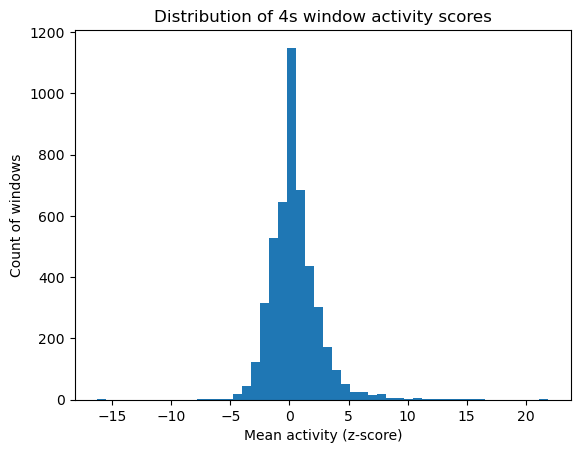

count    4698.000000
mean        0.423050
std         2.143779
min       -16.269478
25%        -0.825362
50%         0.244407
75%         1.314257
max        21.908902
Name: window_activity, dtype: float64


In [82]:
# mean activity per window
scene_candidates = scene_candidates.merge(
    frame_aggr[['video_base','frame12','activity']],
    left_on=['video_base','start_frame12'],
    right_on=['video_base','frame12'],
    how='left'
)
scene_candidates.rename(columns={'activity':'window_activity'}, inplace=True)

plt.hist(scene_candidates['window_activity'], bins=50)
plt.xlabel("Mean activity (z-score)")
plt.ylabel("Count of windows")
plt.title("Distribution of 4s window activity scores")
plt.show()

print(scene_candidates['window_activity'].describe())

In [83]:
lower, upper = scene_candidates['window_activity'].quantile([0.01, 0.99])
scene_candidates['window_activity'] = scene_candidates['window_activity'].clip(lower, upper)

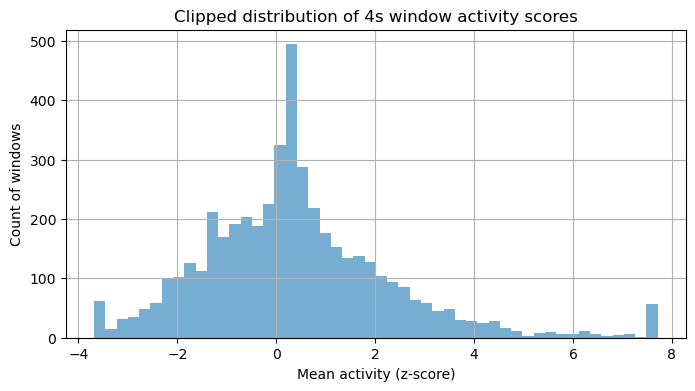

In [84]:
scene_candidates['window_activity'].hist(bins=50, figsize=(8,4), alpha=0.6)
plt.title("Clipped distribution of 4s window activity scores")
plt.xlabel("Mean activity (z-score)")
plt.ylabel("Count of windows")
plt.show()

In [85]:
threshold = scene_candidates['window_activity'].quantile(0.65) # top 35%

best_scenes = scene_candidates[scene_candidates['window_activity'] > threshold]
print(f"{len(best_scenes)} scenes filtered (above {threshold:.2f})")

print(best_scenes[['video_base', 'window_activity']].head())

1643 scenes filtered (above 0.70)
                                video_base  window_activity
1   columpios_cam4-2024-09-25 08:25:18.mp4         3.779656
13  columpios_cam4-2024-09-25 14:58:45.mp4         7.713624
16  columpios_cam4-2024-09-25 15:45:09.mp4         2.062706
24  columpios_cam4-2024-09-25 17:14:39.mp4         0.916877
25  columpios_cam4-2024-09-25 17:14:39.mp4         5.900848


## 5. Pick the best windows (t_start, t_end)

In [86]:
W = 48 # window length = 48 frames (4s)
HALF_GAP = 24  # non-overlap suppression radius (2s)

def pick_top_nonoverlapping(best_scenes_df, half_gap=24, max_windows=None):
    best_scenes_df = best_scenes_df.sort_values('window_activity', ascending=False)
    selected = []
    used = set()
    for _, row in best_scenes_df.iterrows():
        start = row['start_frame12']
        # skip if overlaps with previously selected ones
        if any(abs(start - s) < half_gap for s in used):
            continue
        selected.append(row)
        used.add(start)
        if max_windows and len(selected) >= max_windows:
            break
    return pd.DataFrame(selected)

# Apply per video
picked = (
    best_scenes.groupby('video_base', group_keys=False)
               .apply(lambda g: pick_top_nonoverlapping(g, HALF_GAP, max_windows=3))
               .reset_index(drop=True)
)

picked = picked.sort_values('window_activity', ascending=False)

print("Selected:", len(picked), "non-overlapping windows")
picked.head()

Selected: 1643 non-overlapping windows


/var/folders/mm/tqkf911x79zcxdmhps4b0yfm0000gn/T/ipykernel_43245/1145069968.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pick_top_nonoverlapping(g, HALF_GAP, max_windows=3))


,video_base,start_frame12,t_start_sec,t_end_sec,frame12,window_activity
239,columpios_cam4-2024-11-21 18:53:10.mp4,166.0,13.833333,17.833333,166,7.713624
1152,columpioscam3-2024-09-25 11:41:35.mp4,75.0,6.250000,10.250000,75,7.713624
1244,columpioscam3-2024-10-03 18:29:30.mp4,155.0,12.916667,16.916667,155,7.713624
658,columpioscam1-2024-11-17 10:25:24.mp4,120.0,10.000000,14.000000,120,7.713624
241,columpios_cam4-2024-11-21 19:16:11.mp4,76.0,6.333333,10.333333,76,7.713624


In [87]:
# Merge metadata into picked scenes
meta_cols = [
    'video_base', # match key
    'lat', 'long',
    'timestamp', # original recording time
    'id', 'id_person', # identity info
]

meta_df = (
    df[meta_cols]
    .drop_duplicates('video_base')
    .reset_index(drop=True)
)

picked_meta = picked.merge(meta_df, on='video_base', how='left')
picked_meta.head()

,video_base,start_frame12,t_start_sec,t_end_sec,frame12,window_activity,lat,long,timestamp,id,id_person
0,columpios_cam4-2024-11-21 18:53:10.mp4,166.0,13.833333,17.833333,166,7.713624,25.653061,-100.285843,2024-11-22 00:53:10.041613+00:00,columpios_cam4-2024-11-21_185310.mp4:17527661-...,17527661-d095-4e94-bad5-cf142e0d4a79
1,columpioscam3-2024-09-25 11:41:35.mp4,75.0,6.250000,10.250000,75,7.713624,25.653034,-100.286041,2024-09-25 17:41:35.045100+00:00,columpioscam3-2024-09-25_114135.mp4:96:0,96
2,columpioscam3-2024-10-03 18:29:30.mp4,155.0,12.916667,16.916667,155,7.713624,25.652994,-100.286118,2024-10-04 00:29:30.051348+00:00,columpioscam3-2024-10-03_182930.mp4:66a106a0-b...,66a106a0-bd03-49e9-8418-8c6ae98d020c
3,columpioscam1-2024-11-17 10:25:24.mp4,120.0,10.000000,14.000000,120,7.713624,25.653151,-100.285637,2024-11-17 16:25:24.041494+00:00,columpioscam1-2024-11-17_102524.mp4:85745e56-a...,85745e56-a3e9-4b62-bb2d-c1e8ee152f86
4,columpios_cam4-2024-11-21 19:16:11.mp4,76.0,6.333333,10.333333,76,7.713624,25.653048,-100.285912,2024-11-22 01:16:11.041568+00:00,columpios_cam4-2024-11-21_191611.mp4:addad6d5-...,addad6d5-1fe6-484f-964d-3302e3899325


In [98]:
# Regex pattern for camera name
pattern = r"([a-zA-Z]+(?:_)?cam\d+|galeria)"
picked_meta["camera"] = picked_meta["video_base"].str.extract(pattern, expand=False)

In [100]:
print(len(picked_meta))
picked_meta.head(10)

1643


,video_base,start_frame12,t_start_sec,t_end_sec,frame12,window_activity,lat,long,timestamp,id,id_person,camera
0,columpios_cam4-2024-11-21 18:53:10.mp4,166.0,13.833333,17.833333,166,7.713624,25.653061,-100.285843,2024-11-22 00:53:10.041613+00:00,columpios_cam4-2024-11-21_185310.mp4:17527661-...,17527661-d095-4e94-bad5-cf142e0d4a79,columpios_cam4
1,columpioscam3-2024-09-25 11:41:35.mp4,75.0,6.250000,10.250000,75,7.713624,25.653034,-100.286041,2024-09-25 17:41:35.045100+00:00,columpioscam3-2024-09-25_114135.mp4:96:0,96,columpioscam3
2,columpioscam3-2024-10-03 18:29:30.mp4,155.0,12.916667,16.916667,155,7.713624,25.652994,-100.286118,2024-10-04 00:29:30.051348+00:00,columpioscam3-2024-10-03_182930.mp4:66a106a0-b...,66a106a0-bd03-49e9-8418-8c6ae98d020c,columpioscam3
3,columpioscam1-2024-11-17 10:25:24.mp4,120.0,10.000000,14.000000,120,7.713624,25.653151,-100.285637,2024-11-17 16:25:24.041494+00:00,columpioscam1-2024-11-17_102524.mp4:85745e56-a...,85745e56-a3e9-4b62-bb2d-c1e8ee152f86,columpioscam1
4,columpios_cam4-2024-11-21 19:16:11.mp4,76.0,6.333333,10.333333,76,7.713624,25.653048,-100.285912,2024-11-22 01:16:11.041568+00:00,columpios_cam4-2024-11-21_191611.mp4:addad6d5-...,addad6d5-1fe6-484f-964d-3302e3899325,columpios_cam4
5,columpios_cam4-2024-10-03 16:30:18.mp4,112.0,9.333333,13.333333,112,7.713624,25.653038,-100.285851,2024-10-03 22:30:18.124400+00:00,columpios_cam4-2024-10-03_163018.mp4:d6405baf-...,d6405baf-a503-402e-a958-35232dffe5dd,columpios_cam4
6,columpios_cam4-2024-10-03 16:41:15.mp4,120.0,10.000000,14.000000,120,7.713624,25.653036,-100.285866,2024-10-03 22:41:15.041494+00:00,columpios_cam4-2024-10-03_164115.mp4:120f52d4-...,120f52d4-9aa5-4f23-9588-bdb3832d33e5,columpios_cam4
7,columpioscam2-2024-12-15_14-41-00.mp4,120.0,10.000000,14.000000,120,7.713624,25.653143,-100.285805,2024-12-15 20:41:00.042895+00:00,columpioscam2-2024-12-15_14-41-00.mp4:ada76550...,ada76550-28e9-4658-83a4-395bb2998862,columpioscam2
8,columpioscam2-2024-10-22 22:18:01.mp4,174.0,14.500000,18.500000,174,7.713624,25.653151,-100.285797,2024-10-23 04:18:01.051273+00:00,columpioscam2-2024-10-22_221801.mp4:a1feb7e2-8...,a1feb7e2-8cb7-4de0-bbc9-117b21756495,columpioscam2
9,columpios_cam4-2024-12-13_09-43-00.mp4,114.0,9.500000,13.500000,114,7.713624,25.653152,-100.286018,2024-12-13 15:43:00.044404+00:00,columpios_cam4-2024-12-13_09-43-00.mp4:6416703...,6416703e-178c-4bcb-b1fc-3827eb5bd8a9,columpios_cam4


In [105]:
picked_meta.to_csv('./../../data/videos.csv', index=False)